# Lab 07-2: Convolution Neurak Networks
## Exercise: Predicting MNIST Digits
### For this exercise, prepare Lab 05-3 & Lab 07-1 to copy your previous implementations.

Prepare MNIST Dataset
http://yann.lecun.com/exdb/mnist/

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

tf.config.set_visible_devices([], 'GPU')

(X_train_org, y_train_num), (X_test_org, y_test) = tf.keras.datasets.mnist.load_data()

# Digits data has range of [0,255], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 255
X_train = np.expand_dims(X_train_org / 255, -1)
X_test = np.expand_dims(X_test_org / 255, -1)

n_classes = 10

# Transform Nx1 Y vector to Nx10 answer vector, so that we can perform one-to-all classification
y_train = np.zeros((y_train_num.shape[0], 10))
for i in range(n_classes):
    y_train[:,i] = (y_train_num == i)

# Split training dataset into training and validation
X_val = X_train[50000:60000]
y_val = y_train[50000:60000]

X_train = X_train[:50000]
y_train = y_train[:50000]

n_train = X_train.shape[0]
n_val   = X_val.shape[0]
n_test  = X_test.shape[0]

In [39]:
sim_rate = 1 # 0.2

n_train = int(n_train * sim_rate)
n_val   = int(n_val * sim_rate)
n_test  = int(n_test * sim_rate)

X_train, y_train = X_train[:n_train], y_train[:n_train]
X_test, y_test = X_test[:n_test], y_test[:n_test]
X_val, y_val = X_val[:n_val], y_val[:n_val]

In [40]:
print(n_train, n_val, n_test)

50000 10000 10000


Define Utility Functions

In [41]:
def sigmoid(x):
    # Numerically stable with large exponentials
    x = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return x

def softmax(x):
    # Numerically stable with large exponentials
    x = x - np.max(x, axis=-1, keepdims=True)
    x = np.exp(x)
    xs = np.sum(x, axis=-1, keepdims=True)
    return x / xs

def create_mini_batches(X, y, batch_size=64):
    rnd = np.random.permutation(len(X))
    X_batches, y_batches = X[rnd], y[rnd]
    X_mini = np.split(X_batches, np.arange(batch_size,len(X),batch_size), axis=0)
    y_mini = np.split(y_batches, np.arange(batch_size,len(X),batch_size), axis=0)
    mini_batches = zip(X_mini, y_mini)
    return mini_batches

Show Dataset Information

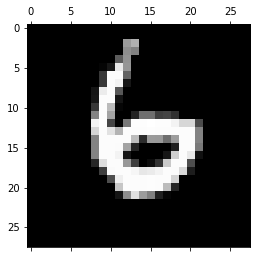

The number is 6
Dataset dimension: (50000, 28, 28, 1)
(50000, 28, 28, 1)
(50000, 10)


In [42]:
idx = np.random.randint(X_test.shape[0])
dimage = tf.reshape(X_test[idx], (28,28))
plt.matshow(dimage)
plt.gray()
plt.show()

print('The number is', y_test[idx])
print('Dataset dimension:', X_train.shape)
# Test code here
print(X_train.shape)
print(y_train.shape)

### Simple CNN for Digit Classification

Prepare Convolution: im2col & col2im (<b>From the previous exercise 07-1</b>)

In [43]:
def im2col(x_img, flt_h, flt_w, stride_h=1, stride_w=1, padding_h=1, padding_w=1):
    x_b, x_h, x_w, x_c = x_img.shape # no of samples, image height, image width, no of channels
    p_h = padding_h
    p_w = padding_w
    ### START CODE HERE ###

    t_x = np.transpose(x_img, (0, 3, 1, 2))   # move h&w to the last
    p_x = np.pad(t_x, ((0,0),(0,0),(p_h,p_h),(p_w,p_w)), 'constant', constant_values=0)   # add paddings
    n_h = (x_h + 2 * p_h - flt_h) // stride_h + 1                                           # find new image height
    n_w = (x_w + 2 * p_w - flt_w) // stride_w + 1                                           # find new image width
    t_col = np.empty((x_b, x_c, n_h, n_w, flt_h, flt_w))                                         # create an empty column matrix
    
    for j in range(n_h):
        h = j * stride_h
        h_l = h + flt_h
        for i in range(n_w):
            w = i * stride_w
            w_l = w + flt_w
            t_col[:,:,j,i,:,:] = p_x[:,:,h:h_l,w:w_l] # copy to the column matrix
    
    x_col = np.transpose(t_col, (0, 2, 3, 4, 5, 1)).reshape(x_b * n_h * n_w, flt_h * flt_w * x_c)                                         # reshpae to 2D column matrix
    
    ### END CODE HERE ###

    return x_col

def col2im(x_col, x_shape, flt_h=1, flt_w=1, stride_h=1, stride_w=1, padding_h=1, padding_w=1):
    x_b, x_h, x_w, x_c = x_shape # no of samples, image height, image width, no of channels
    p_h = padding_h
    p_w = padding_w
    ### START CODE HERE ###

    n_h = (x_h + 2 * p_h - flt_h) // stride_h + 1                                           # find new image height
    n_w = (x_w + 2 * p_w - flt_w) // stride_w + 1                                           # find new image width
    r_col = np.transpose(x_col.reshape(x_b, n_h, n_w, flt_h, flt_w, x_c), (0, 5, 1, 2, 3, 4))                                         # reshape 2D column matrix to 6D
    p_img = np.empty((x_b, x_c, x_h + 2 * p_h, x_w + 2 * p_w))                                         # create an empty padded image

    for j in range(n_h):
        h = j * stride_h
        h_l = h + flt_h
        for i in range(n_w):
            w = i * stride_w
            w_l = w + flt_w
            p_img[:,:,h:h_l,w:w_l] = r_col[:,:,j,i,:,:] # copy to the padded image
    
    t_img = p_img[:,:,p_h:x_h+p_h,p_w:x_h+p_w]                                         # remove paddings from p_img
    x_img = np.transpose(t_img, (0,2,3,1))                                         # restore h&w positions
    
    ### END CODE HERE ###

    return x_img

Define Dense Layer Class (<b>From the previous exercise 05-3</b>)

In [44]:
class myNeuralLayer:
    def __init__(self, n_out, n_in):
        self.wegt = np.zeros((n_out, n_in))
        self.bias = np.zeros((n_out))

    def forward(self, x):                      # (b, i)
        ### START CODE HERE ###

        x_lin = np.matmul(x, self.wegt.T) + self.bias            # Linear Prediction
        
        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, c)
        ### START CODE HERE ###
        
        dw = np.matmul(x.T, x_in) / x.shape[0]               # Gradients for weights
        db = np.mean(x, axis=0)               # Gradients for biases
        wdJdz = np.matmul(x, self.wegt)            # Propagation for lower layer
        
        ### END CODE HERE ###
        return dw, db, wdJdz

Define Convolution Layer Class (<b>From the previous exercise 07-1</b>)

In [45]:
class myConv2DLayer:
    def __init__(self, n_out, flt_h, flt_w, n_in, stride=1, padding=True):
        self.wegt = np.zeros((n_out, flt_h, flt_w, n_in))
        self.bias = np.zeros((n_out,))
        self.f_h = flt_h
        self.f_w = flt_w
        self.f_c = n_out
        self.f_i = n_in
        self.s_h = stride
        self.s_w = stride
        self.p_h = flt_h // 2 if padding else 0
        self.p_w = flt_w // 2 if padding else 0

    def forward(self, x):                   # (fc, fh, fw, fi), (b, h, w, ci)
        x_b, x_h, x_w, _ = x.shape
        ### START CODE HERE ###

        x_h = (x_h + 2 * self.p_h - self.f_h) // self.s_h + 1                          # find new filtered image height; integer
        x_w = (x_w + 2 * self.p_w - self.f_w) // self.s_w + 1                          # find new filtered image width; integer

        c_img = im2col(x, self.f_h, self.f_w, self.s_h, self.s_w, self.p_h, self.p_w)  # convert input image into a column mode matrix
        c_wgt = self.wegt.reshape(self.wegt.shape[0],-1)                        # prepare weight matrix for multiplication with the column mode matrix
        c_lin = np.matmul(c_img, c_wgt.T) + self.bias                        # linear transformation
        x_lin = c_lin.reshape(x_b, x_h, x_w, self.f_c)                        # reshape the result matrix into tensor format

        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, h, w, co), x_in = input (b, h, w, ci)
        x_b, x_h, x_w, x_c = x_in.shape

        ### START CODE HERE ###
        
        # prepare gradients for padding and stride
        st_h = self.f_h // 2 - self.p_h                     # starting index is determined by f_h//2-p_h
        st_w = self.f_w // 2 - self.p_w                     # find the vertical start index after padding
        x_pd = np.zeros((x_b, x.shape[1] + (x.shape[1]-1)*(self.s_h-1), x.shape[2] + (x.shape[2]-1)*(self.s_w-1), self.f_c))                     # create a zero tensor for dilation and padding
        x_pd[:, st_h::self.s_h, st_w::self.s_w, :] = x  # insert gradients into the dilated tensor

        # backpropagation for convolution: weight gradient
        xi_trn = np.transpose(x_in, (3, 1, 2, 0))                   # transpose batch and input channel
        c_tran = im2col(xi_trn, x_pd.shape[1], x_pd.shape[2], 1, 1, self.p_h, self.p_w)  # transfer to column mode matrix
        x_tran = np.transpose(x_pd, (3, 1, 2, 0))                   # move channel of padded gradients to first
        c_x_dz = x_tran.reshape(self.f_c, -1)                   # reshape the gradients for mult
        w_grad = np.matmul(c_x_dz, c_tran.T) / x_b                   # perform multiplication / batch_len
        dw = w_grad.reshape(self.f_c, self.f_h, self.f_w, x_c)                       # prepare weight gradient for output

        # backpropagation for convolution: bias gradient
        b_grad = x_pd.reshape(-1, self.f_c)                   # reshape transposed padded gradient for sum
        db = np.sum(b_grad, axis=0) / x_b                       # perform summation / batch_len

        # backpropagation for convolution: W * dJdz
        c_dJdz = im2col(x_pd, self.f_h, self.f_w, 1, 1, self.p_h, self.p_w)  # transform padded gradient into column mode matrix
        f_wegt = np.flip(self.wegt, axis=(1,2))                   # reverse weight parameter orders horizontally & vertically
        c_wegt = np.transpose(f_wegt, (3, 1, 2, 0)).reshape(x_c, -1)                   # prepare the reversed weight for multiplication
        w_dJda = np.matmul(c_dJdz, c_wegt.T)                   # perform multiplication
        wdJdz = w_dJda.reshape(x_b, x_h, x_w, x_c)                    # reshape result for transferring to lower

        ### END CODE HERE ###
        return dw, db, wdJdz

Pooling Function: MaxPool, AvgPool. GlobalPool (<b>From the previous exercise 07-1</b>)

In [46]:
def pooling(x_img, flt_h, flt_w, stride_h=1, stride_w=1, filter_type='max', padding=False):
    x_b, x_h, x_w, x_c = x_img.shape # no of samples, no of channels, image height, image width
    padding_h, padding_w = (flt_h//2, flt_w//2) if padding else (0, 0)

    ### START CODE HERE ###

    t_img = np.transpose(x_img, (0,3,1,2))                           # move h & w to back
    r_img = t_img.reshape(x_b * x_c, x_h, x_w, 1)                           # merge b & ch, and prepare it for im2col (4-D)
    x_col = im2col(r_img, flt_h, flt_w, stride_h, stride_w, padding_h, padding_w)  # convert the matrix to column mode
    n_h = (x_h + 2 * padding_h - flt_h) // stride_h + 1                             # find new image height
    n_w = (x_w + 2 * padding_w - flt_w) // stride_w + 1                             # find new image width

    if filter_type=='max':
        pmask = np.zeros_like(x_col)       # zeros of the column matrix shape
        pmask[np.arange(x_col.shape[0]), np.argmax(x_col, axis=1)] = 1  # set the max location to 1
        pmask = col2im(pmask, r_img.shape, flt_h, flt_w, stride_h, stride_w, padding_h, padding_w)  # inverse im2col
        pmask = np.transpose(pmask.reshape(t_img.shape), (0, 2, 3, 1))                       # reverse to input shape
        x_new = np.max(x_col, axis=1)                       # find the max in column
        x_new = np.transpose(x_new.reshape(x_b, x_c, n_h, n_w), (0, 2, 3, 1))                       # reshape & transpose to the new image dims
    elif filter_type=='average':
        pmask = np.empty_like(x_img)       # just pass the input shape
        x_new = np.mean(x_col, axis=1)                       # find the colummn average
        x_new = np.transpose(x_new.reshape(x_b, x_c, n_h, n_w), (0, 2, 3, 1))                       # reshape & transpose to the new image dims
    elif filter_type=='global':
        pmask = np.empty_like(x_img)       # just pass the input shape
        f_img = x_col.reshape(r_img.shape[0], -1)                       # flatten images except batch
        x_new = np.mean(f_img, axis=1)                       # find the image average
        x_new = x_new.reshape(x_b, x_c)                       # reshape to the new output dims

    ### END CODE HERE ###
    else:
        print('pooling type error')
        
    return x_new, pmask

Define Pooling Layer (<b>From the previous exercise 07-1</b>)

In [47]:
class myPoolingLayer:
    def __init__(self, flt_h, flt_w, stride_h, stride_w, p_type='max'):
        self.type = p_type
        self.f_h = flt_h
        self.f_w = flt_w
        self.s_h = stride_h
        self.s_w = stride_w
        self.mask = None

    def forward(self, x):
        x, m = pooling(x, self.f_h, self.f_w, self.s_h, self.s_w, self.type, padding=False)
        self.mask = m
        return x

    # To support backward path of overlapping-pooling this function requires the original image
    # because of overlapped filtering area where the gradient affects. (especially max mode)
    # In this implementation we ignore the cases of of overlapping-pooling.
    def backward(self, x):
        (img_b, img_h, img_w, img_c) = self.mask.shape
        ### START CODE HERE ###

        if self.type=='max':
            # backpropagation for max pooling; repeat max and filter out non-max
            x_eh = np.repeat(x, img_w//x.shape[2], axis=2)                             # repeat vertically on h-axis
            x_ex = np.repeat(x_eh, img_h//x.shape[1], axis=1)                             # repeat horizontally on w-axis
            x_gr = self.mask * x_ex                             # filter out non-max locations
        elif self.type=='average':
            # backpropagation for average pooling; repeat average and divide by n
            x_eh = np.repeat(x, img_w//x.shape[2], axis=2)                             # repeat vertically on h-axis
            x_ex = np.repeat(x_eh, img_h//x.shape[1], axis=1)                             # repeat horizontally on w-axis
            x_gr = x_ex / (img_h//x.shape[1] * img_w//x.shape[2])                             # divide by n of filter elements
        elif self.type=='global':
            x_b, x_c = x.shape
            # backpropagation for global pooling; repeat average and divide by N
            x_ed = x.reshape(x_b, 1, 1, x_c)                             # reshape to 4D
            x_eh = np.repeat(x_ed, img_w, axis=2)                             # repeat vertically on h-axis
            x_ex = np.repeat(x_eh, img_h, axis=1)                             # repeat horizontally on w-axis
            x_gr = x_ex / (img_h * img_w)                             # divide by N of filter elements

        ### END CODE HERE ###
        else:
            print('pooling type error in backward')
            
        return x_gr

Define Backpropagation of Activation Functions (<b>Some from the previous exercise 05-3</b>)

In [48]:
def dJdz_sigmoid(wdJdz_upper, az):
    ### START CODE HERE ###

    dJdz = wdJdz_upper * az * (1 - az)            # backpropagation through activation function

    ### END CODE HERE ###
    return dJdz

def dJdz_softmax(y_hat, y):
    ### START CODE HERE ###

    dJdz = y_hat - y            # backpropagation through activation function
    
    ### END CODE HERE ###
    return dJdz

def relu(x):
    return np.where(x<0, 0, x)

def dJdz_relu(wdJdz_upper, x):
    return wdJdz_upper * np.where(x>0,1,0)

Define Training Functions

In [49]:
def my_forward(l1, p1, l2, p2, l3, X_in):
    ### START CODE HERE ###

    a_1 = relu(l1.forward(X_in))                   # first layer forward path
    p_1 = p1.forward(a_1)                   # pooling for the first layer
    a_2 = relu(l2.forward(p_1))                   # second layer forward path
    p_2 = p2.forward(a_2)                   # pooling for the second layer
    a_3 = softmax(l3.forward(p_2))                   # last layer for classification

    ### END CODE HERE ###
    return a_1, p_1, a_2, p_2, a_3

def my_backward(l1, p1, l2, p2, l3, a_1, p_1, a_2, p_2, a_3, X_in, y_true):
    ### START CODE HERE ###

    dw_3, db_3, wdJdz_3 = l3.backward(dJdz_softmax(a_3, y_true), p_2)   # the last layer backward
    dJdp_2              = p2.backward(wdJdz_3)   # second pooling backpropagation
    dw_2, db_2, wdJdz_2 = l2.backward(dJdz_relu(dJdp_2, a_2), p_1)   # the second layer backward
    dJdp_1              = p1.backward(wdJdz_2)   # first pooling backpropagation
    dw_1, db_1, _       = l1.backward(dJdz_relu(dJdp_1, a_1), X_in)   # the first layer backward

    ### END CODE HERE ###
    d_1 = [dw_1, db_1]
    d_2 = [dw_2, db_2]
    d_3 = [dw_3, db_3]
    return d_1, d_2, d_3

def my_loss(l1, p1, l2, p2, l3, X_in, y_true):
    ### START CODE HERE ###

    # forward path
    a_1 = relu(l1.forward(X_in))                   # first layer forward path
    p_1 = p1.forward(a_1)                   # pooling for the first layer
    a_2 = relu(l2.forward(p_1))                   # second layer forward path
    p_2 = p2.forward(a_2)                   # pooling for the second layer
    a_3 = softmax(l3.forward(p_2))                   # last layer for classification

    # calculate loss & accuracy
    loss = -np.mean(y_true * np.log(a_3))                  # calculate loss
    equl = np.where(y_true)[1] == np.argmax(a_3, axis=1)                  # check if prediction is equal to the ground truth
    acc =  np.mean(equl)                  # calculate accuracy; rate of correctness
    
    ### END CODE HERE ###
    return loss, acc
    
def my_predict(l1, p1, l2, p2, l3, X_in):
    ### START CODE HERE ###

    # forward path
    a_1 = relu(l1.forward(X_in))                   # first layer forward path
    p_1 = p1.forward(a_1)                   # pooling for the first layer
    a_2 = relu(l2.forward(p_1))                   # second layer forward path
    p_2 = p2.forward(a_2)                   # pooling for the second layer
    a_3 = softmax(l3.forward(p_2))                   # last layer for classification

    # make prediction
    pred = np.argmax(a_3, axis=1)                  # predict digit

    ### END CODE HERE ###
    return pred

Create a CNN model and check the matrix dimensions

In [50]:
# define network
in_c = 1
h1_c = 16
h2_c = 32

l1 = myConv2DLayer(n_out=h1_c, flt_h=3, flt_w=3, n_in=in_c, stride=1, padding=True)     # (28, 28, in_c) -> (28, 28, h1_c)
p1 = myPoolingLayer(flt_h=2, flt_w=2, stride_h=2, stride_w=2, p_type='max') # (28, 28, h1_c) -> (14, 14, h1_c)
l2 = myConv2DLayer(n_out=h2_c, flt_h=3, flt_w=3, n_in=h1_c, stride=1, padding=True)    # (14, 14, h1_c) -> (14, 14, h2_c)
p2 = myPoolingLayer(flt_h=2, flt_w=2, stride_h=2, stride_w=2, p_type='global') # (14, 14, h2_c) -> (h2_c,)
l3 = myNeuralLayer(n_out=n_classes, n_in=h2_c)               # (h2_c,) -> (n_classes,)

print(X_train.shape, y_train.shape)
print(l1.wegt.shape, l1.bias.shape)
print(l2.wegt.shape, l2.bias.shape)
print(l3.wegt.shape, l3.bias.shape)

(50000, 28, 28, 1) (50000, 10)
(16, 3, 3, 1) (16,)
(32, 3, 3, 16) (32,)
(10, 32) (10,)


Initialize Weights

In [51]:
def my_initializer(lyr, pdf='normal'):   # probability density function
    w_shape = lyr.wegt.shape                # (c, i)

    if   len(w_shape)==2:
        fan_out, fan_in = w_shape
    elif len(w_shape)==4:
        fan_out, fan_in = w_shape[0] , w_shape[1] * w_shape[2] * w_shape[3]
    else:
        print ('parameter shape error')

    if pdf=='normal':
        lyr.wegt = np.random.randn(*w_shape)
    elif pdf=='uniform':
        lyr.wegt = np.random.rand(*w_shape)
    elif pdf=='xavier_normal':           # Xavier is also known as Glorot
        lyr.wegt = np.random.randn(*w_shape) * np.sqrt(2/(fan_out + fan_in))
    elif pdf=='xavier_uniform':
        lyr.wegt = np.random.rand(*w_shape) * np.sqrt(6/(fan_out + fan_in))
    elif pdf=='he_normal':
        lyr.wegt = np.random.randn(*w_shape) * np.sqrt(2/fan_in)
    elif pdf=='he_uniform':
        lyr.wegt = np.random.rand(*w_shape) * np.sqrt(6/fan_in)
    else:
        print('initializer error')
    return

# Weights are initialized to...
weight_init = 'he_normal'

my_initializer(l1, pdf=weight_init)
my_initializer(l2, pdf=weight_init)
my_initializer(l3, pdf=weight_init)

Define Various Optimizers

In [52]:
class myOptParam:
    def __init__(self, w_shape):

        # Previoud delta values for momentum optimizer
        self.W_dt = np.zeros(w_shape)
        self.B_dt = np.zeros(w_shape[0])
        # Variables for other optimizers
        self.W_mt = np.zeros(w_shape)
        self.B_mt = np.zeros(w_shape[0])
        self.W_vt = np.zeros(w_shape)
        self.B_vt = np.zeros(w_shape[0])
        # Variable for Adam optimizer
        self.iter = 0

def my_optimizer(lyr, opt, W_grad, B_grad, solver='sgd', learning_rate=0.01, iter=3):
    epsilon = 1e-8  # arbitrary small number
    alpha = eta = learning_rate
    if iter!=0:
        opt.iter = iter

    # optimizer routines
    if  solver=='sgd':
        W_dlt = alpha * W_grad
        B_dlt = alpha * B_grad
    elif solver=='momentum':
        gamma = 0.9               # default setting
        ### START CODE HERE ###
        
        W_dlt = gamma * opt.W_dt + alpha * W_grad              # momentum for previous delta
        B_dlt = gamma * opt.B_dt + alpha * B_grad              # same goes for bias
        opt.W_dt = W_dlt           # keep data for later use
        opt.B_dt = B_dlt           # for bias, too

        ### END CODE HERE ###
    elif solver=='adagrad':
        ### START CODE HERE ###

        opt.W_vt = opt.W_vt + W_grad**2           # accumulate delta square (2nd momentum)
        opt.B_vt = opt.B_vt + B_grad**2           # accumulater for bias term
        W_dlt = eta / np.sqrt(epsilon + opt.W_vt) * W_grad              # calculate new delta for weight
        B_dlt = eta / np.sqrt(epsilon + opt.B_vt) * B_grad              # and for bias

        ### END CODE HERE ###
    elif solver=='rmsprop':
        beta2 = 0.9               # default setting
        ### START CODE HERE ###

        opt.W_vt = beta2 * opt.W_vt + (1 - beta2) * W_grad**2           # blending with second momentum
        opt.B_vt = beta2 * opt.B_vt + (1 - beta2) * B_grad**2           # also doging samething for bias
        W_dlt = eta / np.sqrt(epsilon + opt.W_vt) * W_grad              # calculate new delta for weight
        B_dlt = eta / np.sqrt(epsilon + opt.B_vt) * B_grad              # and for bias
        
        ### END CODE HERE ###
    elif solver=='adam':
        beta1, beta2 = 0.9, 0.99  # default setting
        ### START CODE HERE ###

        opt.W_mt = beta1 * opt.W_mt + (1 - beta1) * W_grad           # blending with first momentum
        opt.B_mt = beta1 * opt.B_mt + (1 - beta1) * B_grad           # first momentum for bias
        opt.W_vt = beta2 * opt.W_vt + (1 - beta2) * W_grad**2           # blending with second momentum
        opt.B_vt = beta2 * opt.B_vt + (1 - beta2) * B_grad**2           # second momentum for bias
        W_mc = opt.W_mt / (1 - beta1**iter)               # bias correction of first momentum for weight
        B_mc = opt.B_mt / (1 - beta1**iter)               # and for bias term
        W_vc = opt.W_vt / (1 - beta2**iter)               # bias correction of second momentum for weight
        B_vc = opt.B_vt / (1 - beta2**iter)               # and for bias term
        W_dlt = eta / (np.sqrt(W_vc) + epsilon) * W_mc              # calculate new delat for weight
        B_dlt = eta / (np.sqrt(B_vc) + epsilon) * B_mc              # and for bias
        
        ### END CODE HERE ###
    else:  
        print('optimizer error')

    # Adjust weight
    lyr.wegt = lyr.wegt - W_dlt
    lyr.bias = lyr.bias - B_dlt

    return

Create Optimizer Parameters

In [53]:
o1 = myOptParam(l1.wegt.shape)
o2 = myOptParam(l2.wegt.shape)
o3 = myOptParam(l3.wegt.shape)

Training Simple Convolution Neural Network Model (3 layer model)

In [54]:
# tqdm library shows loop progress
from tqdm.notebook import tqdm

batch_size = 64
steps = np.ceil(len(X_train) / batch_size)
print(steps)

782.0


In [55]:
# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
# alpha is learning rate
optimizer ='adam'
alpha = 0.001
n_epochs = 20

start = time.time()
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(n_epochs):

    batches = create_mini_batches(X_train, y_train, batch_size=64)

    pbar = tqdm(batches, total=steps)
    pbar.set_description('Epoch:%2d' % (epoch+1))

    for one_batch in pbar:
        X_mini, y_mini = one_batch
        batch_len = X_mini.shape[0]  # last batch might have different length

        # Forward Path
        a_1, p_1, a_2, p_2, a_3 = my_forward(l1, p1, l2, p2, l3, X_mini)

        # Backward Path
        d_1, d_2, d_3 = my_backward(l1, p1, l2, p2, l3, a_1, p_1, a_2, p_2, a_3, X_mini, y_mini)

        dw_1, db_1 = d_1
        dw_2, db_2 = d_2
        dw_3, db_3 = d_3
        
        lr = alpha # * (1 - epoch / (2*n_epochs))

        # Update weights and biases
        my_optimizer(l1, o1, dw_1, db_1, solver=optimizer, learning_rate=lr)
        my_optimizer(l2, o2, dw_2, db_2, solver=optimizer, learning_rate=lr)
        my_optimizer(l3, o3, dw_3, db_3, solver=optimizer, learning_rate=lr)

    if ((epoch+1)%1==0):

        loss_J, acc_J = my_loss(l1, p1, l2, p2, l3, X_train[:n_val], y_train[:n_val])
        loss_V, acc_V = my_loss(l1, p1, l2, p2, l3, X_val, y_val)
        print('Epoch: %4d, Elapsed_t: %4.2fs loss: %10.8f acc: %10.8f - val_loss: %10.8f val_acc: %10.8f' \
              % (epoch+1, time.time() - start, loss_J, acc_J, loss_V, acc_V))
        start = time.time()
        history['loss'].append(loss_J), history['acc'].append(acc_J)
        history['val_loss'].append(loss_V), history['val_acc'].append(acc_V)

  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:    1, Elapsed_t: 287.65s loss: 0.19579580 acc: 31.77000000 - val_loss: 0.19549976 val_acc: 31.34000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:    2, Elapsed_t: 296.34s loss: 0.16575317 acc: 44.13000000 - val_loss: 0.16565278 val_acc: 44.17000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:    3, Elapsed_t: 303.31s loss: 0.14933376 acc: 48.01000000 - val_loss: 0.14863250 val_acc: 48.91000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:    4, Elapsed_t: 299.04s loss: 0.13666706 acc: 55.29000000 - val_loss: 0.13455848 val_acc: 57.00000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:    5, Elapsed_t: 319.72s loss: 0.12701671 acc: 57.72000000 - val_loss: 0.12424030 val_acc: 59.31000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:    6, Elapsed_t: 324.23s loss: 0.11924371 acc: 60.60000000 - val_loss: 0.11627704 val_acc: 61.83000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:    7, Elapsed_t: 373.39s loss: 0.11353380 acc: 62.94000000 - val_loss: 0.11014088 val_acc: 64.32000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:    8, Elapsed_t: 363.82s loss: 0.10841566 acc: 65.26000000 - val_loss: 0.10481459 val_acc: 65.77000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:    9, Elapsed_t: 392.81s loss: 0.10380804 acc: 67.52000000 - val_loss: 0.09975908 val_acc: 68.13000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   10, Elapsed_t: 357.23s loss: 0.10046958 acc: 68.35000000 - val_loss: 0.09630573 val_acc: 69.61000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   11, Elapsed_t: 489.43s loss: 0.10071588 acc: 67.03000000 - val_loss: 0.09628906 val_acc: 68.46000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   12, Elapsed_t: 382.34s loss: 0.09439700 acc: 71.75000000 - val_loss: 0.09010697 val_acc: 72.85000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   13, Elapsed_t: 351.75s loss: 0.09249617 acc: 71.75000000 - val_loss: 0.08820038 val_acc: 72.57000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   14, Elapsed_t: 376.68s loss: 0.09029998 acc: 72.20000000 - val_loss: 0.08567079 val_acc: 73.72000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   15, Elapsed_t: 390.87s loss: 0.08871784 acc: 73.42000000 - val_loss: 0.08428218 val_acc: 74.22000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   16, Elapsed_t: 393.86s loss: 0.08606697 acc: 74.57000000 - val_loss: 0.08183923 val_acc: 75.18000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   17, Elapsed_t: 368.95s loss: 0.08516511 acc: 74.11000000 - val_loss: 0.08079784 val_acc: 75.51000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   18, Elapsed_t: 342.13s loss: 0.08396739 acc: 72.45000000 - val_loss: 0.07955689 val_acc: 73.35000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   19, Elapsed_t: 393.74s loss: 0.08064582 acc: 76.34000000 - val_loss: 0.07624996 val_acc: 77.14000000


  0%|          | 0/782.0 [00:00<?, ?it/s]

Epoch:   20, Elapsed_t: 366.47s loss: 0.08025635 acc: 75.54000000 - val_loss: 0.07610839 val_acc: 76.27000000


Plot loss and accuracy

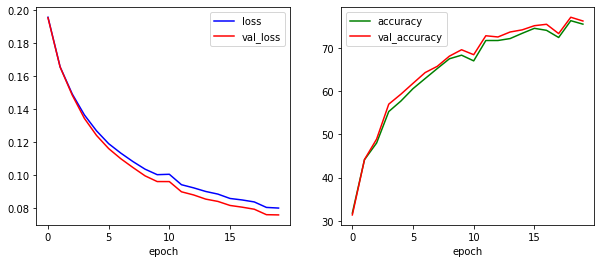

In [56]:
# plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], 'b-', label='loss')
plt.plot(history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['acc'], 'g-', label='accuracy')
plt.plot(history['val_acc'], 'r-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

Evaluate Model Performance

In [57]:
from sklearn.metrics import accuracy_score

y_pred = my_predict(l1, p1, l2, p2, l3, X_test)

accuracy_score(y_pred, y_test)

0.7628

### Test Model with a random sample


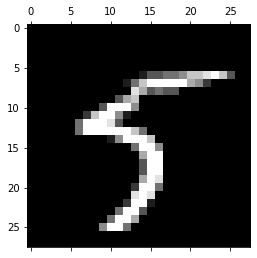

My prediction is 5
Actual number is 5


In [58]:
idx = np.random.randint(X_test.shape[0])
plt.matshow(X_test_org[idx])
plt.gray()
plt.show()

X_input = np.expand_dims(X_test[idx], 0)

y_pred = my_predict(l1, p1, l2, p2, l3, X_input)

print('My prediction is ' + str(y_pred[0]))
print('Actual number is ' + str(y_test[idx]))